<a href="https://colab.research.google.com/github/moeenkhurram/Sentiment-analysis-on-Twitter-data/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import re
import string
import pandas as pd
DATASET_ENCODING = "ISO-8859-1"
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud 


nltk.download('movie_reviews')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

# Global Parameters
stop_words = set(stopwords.words('english'))

pd.set_option('display.max_colwidth', 150)



[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# About Dataset


Dataset: [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)

This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .
It contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)
The official link regarding the dataset with resources about how it was generated is here
The official paper detailing the approach is here

According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [3]:
colnames=['target','ids' ,'date','flag','user','text']
df = pd.read_csv("/content/gdrive/My Drive/archive.zip",encoding=DATASET_ENCODING, names=colnames, header=None)
df = df.sample(int(len(df)/2)).reset_index(drop=True)
df.shape

(800000, 6)

In [4]:
df= df.iloc[:,[0,-1]]
df.columns = ['sentiment','tweet']
#df = pd.concat([df.query("sentiment==0").sample(20000,  random_state=7),df.query("sentiment==4").sample(20000, random_state=7)])
df.sentiment = df.sentiment.map({0:0, 4:1})
df

,sentiment,tweet
0,1,Greg:Showing my friends AudioBoo http://audioboo.fm/ Everyone seems 2 love it. Ta for the headzup bro. So need 2 get iPhone. Roll on June
1,1,@MrTeagan can't wait to see them both on the 14th. signed posters or pics available at the booth? will be there on the 14th.
2,0,wants something to go right today!!
3,0,HAHUUUU not ready for tomorrow
4,0,@Baby_Lexie awww..may she rest in peace...
...,...,...
799995,1,@triiiiciaaaa i'm gonna check them out some time.
799996,1,@GreenyAndGolic Mark Schlereth is the sweetest dad in the world!! His story made me cry
799997,0,@Kacizzle88 i'm sorry about your night lemme get you a drink
799998,1,@dkmashino Mahalos brah for the #FF! I always enjoy your f*cken tweets!


In [5]:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove retweets:
    tweet = re.sub(r'RT : ', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    
    return " ".join(lemma_words)

In [6]:
df['tweet'] = df['tweet'].apply(preprocess_tweet_text)
df

,sentiment,tweet
0,1,GregShowing friends AudioBoo Everyone seems 2 love Ta headzup bro So need 2 get iPhone Roll June
1,1,cant wait see 14th signed posters pics available booth 14th
2,0,wants something go right today
3,0,HAHUUUU ready tomorrow
4,0,rest peace
...,...,...
799995,1,im gon na check time
799996,1,Mark Schlereth sweet dad world His story made cry
799997,0,im sorry night lem get drink
799998,1,Mahalos brah FF I always enjoy fcken tweets


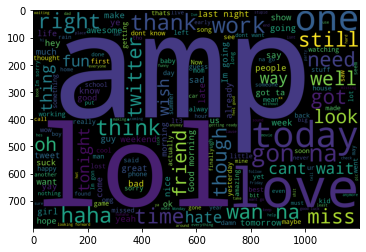

In [7]:
# Creating a word cloud
words = ' '.join([tweet for tweet in df['tweet']])
wordCloud = WordCloud(width=1200, height=800).generate(words)

plt.imshow(wordCloud)
plt.show()

# TextBlob

In [8]:
from textblob import TextBlob
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

blobber = Blobber(analyzer=NaiveBayesAnalyzer())

blob = blobber("The movie was good, I do not want to watch it agian")
print(blob.sentiment)

Sentiment(classification='neg', p_pos=0.48168014942308357, p_neg=0.5183198505769168)


In [9]:
df1 = df.copy()

In [10]:
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity


In [11]:
df1['Subjectivity'] =     df1['tweet'].apply(getTextSubjectivity)
df1['Polarity']     =     df1['tweet'].apply(getTextPolarity)

In [12]:
# negative, nautral, positive analysis 
def Sentiments_Score(tweet):
    if tweet < 0:
        return "Negative"
    elif tweet == 0:
        return "Neutral"
    else:
        return "Positive"    

df1['Predicition_Textblob'] = df1['Polarity'].apply(Sentiments_Score)

In [13]:
df1.sample(9)

,sentiment,tweet,Subjectivity,Polarity,Predicition_Textblob
757005,0,Flipping channels sad see UFC stuffguy 8 year old daughter fightingsurprised see Zappos sponsor,0.600000,-0.200000,Negative
144882,1,Yay raining,0.000000,0.000000,Neutral
662790,1,More pretty flowers My friends nice Japanese garden,0.625000,0.337500,Positive
306556,0,You wont hate I put name parents invitation Im worrying stupid things,0.950000,-0.800000,Negative
616155,1,Yeah road rules force anything gt 1 wheel,0.000000,0.000000,Neutral
613542,0,cant get one work,0.000000,0.000000,Neutral
709823,1,hohum really like himmm,0.200000,0.200000,Positive
295693,0,ohh noo tha awful im sure itll fine,0.796296,-0.027778,Negative
498518,0,Off 2 work Y days go quick,0.500000,0.333333,Positive


<BarContainer object of 3 artists>

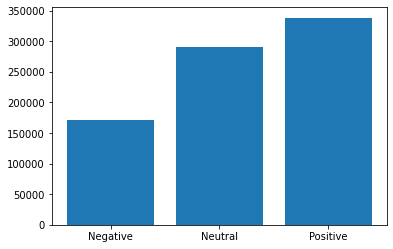

In [14]:
plt.bar(df1.groupby('Predicition_Textblob').count().index.values, df1.groupby('Predicition_Textblob').size().values) 

## Vader Sentiment

In [15]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [16]:
df2= df.copy()

In [17]:
df2

,sentiment,tweet
0,1,GregShowing friends AudioBoo Everyone seems 2 love Ta headzup bro So need 2 get iPhone Roll June
1,1,cant wait see 14th signed posters pics available booth 14th
2,0,wants something go right today
3,0,HAHUUUU ready tomorrow
4,0,rest peace
...,...,...
799995,1,im gon na check time
799996,1,Mark Schlereth sweet dad world His story made cry
799997,0,im sorry night lem get drink
799998,1,Mahalos brah FF I always enjoy fcken tweets


In [18]:
df2['Predicition_Vader']=''

def Vader_Sentiment(df2):
    df2["neg"] = df2["tweet"].apply(lambda x:analyser.polarity_scores(x)["neg"])
    df2['neu'] = df2['tweet'].apply(lambda x:analyser.polarity_scores(x)['neu'])
    df2['pos'] = df2['tweet'].apply(lambda x:analyser.polarity_scores(x)['pos'])
    df2['compound'] = df2['tweet'].apply(lambda x:analyser.polarity_scores(x)['compound'])
    
    # negative, nautral, positive analysis 
    df2.loc[df2.compound>0,'Predicition_Vader']='Positive'
    df2.loc[df2.compound==0,'Predicition_Vader']='Neutral'
    df2.loc[df2.compound<0,'Predicition_Vader']='Negative'

    return df2

In [19]:
df2 = Vader_Sentiment(df2)

In [20]:
df2

,sentiment,tweet,Predicition_Vader,neg,neu,pos,compound
0,1,GregShowing friends AudioBoo Everyone seems 2 love Ta headzup bro So need 2 get iPhone Roll June,Positive,0.000,0.640,0.360,0.8074
1,1,cant wait see 14th signed posters pics available booth 14th,Neutral,0.000,1.000,0.000,0.0000
2,0,wants something go right today,Neutral,0.000,1.000,0.000,0.0000
3,0,HAHUUUU ready tomorrow,Positive,0.000,0.444,0.556,0.3612
4,0,rest peace,Positive,0.000,0.222,0.778,0.5423
...,...,...,...,...,...,...,...
799995,1,im gon na check time,Neutral,0.000,1.000,0.000,0.0000
799996,1,Mark Schlereth sweet dad world His story made cry,Negative,0.237,0.534,0.229,-0.0258
799997,0,im sorry night lem get drink,Negative,0.206,0.794,0.000,-0.0772
799998,1,Mahalos brah FF I always enjoy fcken tweets,Positive,0.000,0.426,0.574,0.7739


<BarContainer object of 3 artists>

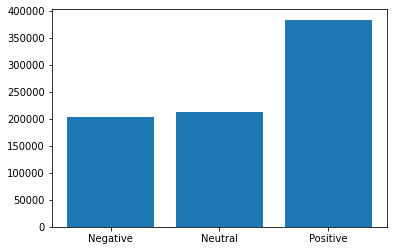

In [21]:
plt.bar(df2.groupby('Predicition_Vader').count().index.values,  df2.groupby('Predicition_Vader').size().values)

In [22]:
df3=df.copy()

In [23]:
df3

,sentiment,tweet
0,1,GregShowing friends AudioBoo Everyone seems 2 love Ta headzup bro So need 2 get iPhone Roll June
1,1,cant wait see 14th signed posters pics available booth 14th
2,0,wants something go right today
3,0,HAHUUUU ready tomorrow
4,0,rest peace
...,...,...
799995,1,im gon na check time
799996,1,Mark Schlereth sweet dad world His story made cry
799997,0,im sorry night lem get drink
799998,1,Mahalos brah FF I always enjoy fcken tweets


In [24]:
# 0: Negative
# 1: Positive

print(df3.tweet[100])
print(df3.sentiment[100])


Friday couldnt come slowerBut im glad
1


In [25]:
training_size = int(len(df3.tweet) * 0.8)

X_train = df3.tweet[0: training_size].values
X_test = df3.tweet[: training_size].values

y_train = df3.sentiment[0: training_size].values
y_test = df3.sentiment[: training_size].values

# Put labels into list to use later:

In [26]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer(oov_token="<OOV>")
tokenizer_obj.fit_on_texts(X_train) 

vocab_size = len(tokenizer_obj.word_index) + 1
max_length = 100

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post', truncating='post')

X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post', truncating='post')

In [27]:
import tensorflow as tf

model = tf.keras.models.Sequential()
embedding_dim = 16
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim , input_length=max_length))
model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(embedding_dim, return_sequences=True)))
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           3809056   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 32)           4224      
_________________________________________________________________
dense (Dense)                (None, 100, 12)           396       
_________________________________________________________________
dense_1 (Dense)              (None, 100, 1)            13        
Total params: 3,813,689
Trainable params: 3,813,689
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
from keras import backend as K 
K.clear_session()

In [29]:

num_epochs=5
history = model.fit(X_train_pad, y_train, 
                    epochs = num_epochs,
                    batch_size=256,
                    validation_data=(X_test_pad, y_test),
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, mode='auto')
)

Epoch 1/5
2500/2500 [==============================] - 153s 48ms/step - loss: 0.5927 - accuracy: 0.6886 - val_loss: 0.4200 - val_accuracy: 0.8123
Epoch 2/5
2500/2500 [==============================] - 119s 48ms/step - loss: 0.4078 - accuracy: 0.8164 - val_loss: 0.3359 - val_accuracy: 0.8571
Epoch 3/5
2500/2500 [==============================] - 119s 48ms/step - loss: 0.3312 - accuracy: 0.8564 - val_loss: 0.2778 - val_accuracy: 0.8828
Epoch 4/5
2500/2500 [==============================] - 119s 47ms/step - loss: 0.2801 - accuracy: 0.8787 - val_loss: 0.2452 - val_accuracy: 0.8973
Epoch 5/5
2500/2500 [==============================] - 119s 47ms/step - loss: 0.2485 - accuracy: 0.8918 - val_loss: 0.2256 - val_accuracy: 0.9050


Text(0, 0.5, 'Accuracy')

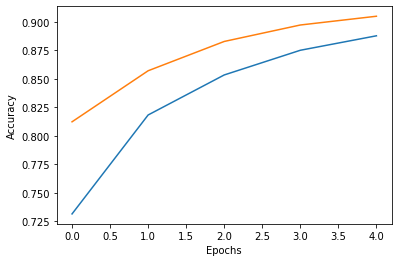

In [30]:
# Decrease because the early stopping

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')



Text(0, 0.5, 'loss')

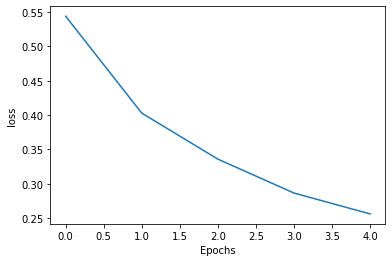

In [31]:
plt.plot(history.history['loss'])

plt.xlabel('Epochs')
plt.ylabel('loss')

Testing

In [42]:
# Use the model to predict Tweeets  

Test_Tweet =  ['I love this phone',]

print(Test_Tweet) 

# Create the sequences

Test_Tweet_sequences = tokenizer_obj.texts_to_sequences(Test_Tweet)
Test_Tweet_padded = pad_sequences(Test_Tweet_sequences, maxlen=max_length, padding="post" )           

prediciton = model.predict(Test_Tweet_padded, batch_size=3)

['I love this phone']


In [43]:
if(np.argmax(prediciton) == 0):
    print("negative")
elif (np.argmax(prediciton) == 1):
    print("positive")

positive


In [44]:
np.round(np.argmax(prediciton), decimals=2)

1

In [40]:
prediciton

array([[[0.8515382 ],
        [0.87227076],
        [0.7942164 ],
        [0.78004885],
        [0.79574746],
        [0.8051536 ],
        [0.8112655 ],
        [0.81417114],
        [0.81539506],
        [0.8158131 ],
        [0.8158558 ],
        [0.81573284],
        [0.81553525],
        [0.8153047 ],
        [0.8150618 ],
        [0.81481767],
        [0.81457883],
        [0.81434935],
        [0.8141314 ],
        [0.81392616],
        [0.8137342 ],
        [0.8135552 ],
        [0.81338865],
        [0.81323415],
        [0.81309086],
        [0.81295806],
        [0.81283486],
        [0.8127207 ],
        [0.8126148 ],
        [0.81251633],
        [0.81242496],
        [0.81234   ],
        [0.81226087],
        [0.81218725],
        [0.81211865],
        [0.8120546 ],
        [0.8119948 ],
        [0.811939  ],
        [0.81188697],
        [0.8118382 ],
        [0.81179273],
        [0.8117501 ],
        [0.81171024],
        [0.811673  ],
        [0.8116381 ],
        [0